In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# some 3-dim points
mean = np.array([0.0,0.0,0.0])
cov = np.array([[1.0,-0.5,0.8], [-0.5,1.1,0.0], [0.8,0.0,1.0]])
data = np.random.multivariate_normal(mean, cov, 50)

In [3]:
# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(-3.0, 3.0, 0.5), np.arange(-3.0, 3.0, 0.5))
XX = X.flatten()
YY = Y.flatten()

In [4]:
order = 2    # 1: linear, 2: quadratic
if order == 1:
    # best-fit linear plane
    A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
    # evaluate it on grid
    Z = C[0]*X + C[1]*Y + C[2]
    
    # or expressed using matrix/vector product
    #Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)

elif order == 2:
    # best-fit quadratic curve
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    # evaluate it on a grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
    


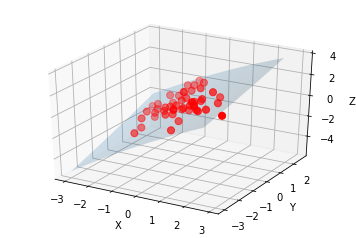

In [5]:
# plot points and fitted surface
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')
plt.show()

In [6]:
from scipy import special
from scipy.optimize import curve_fit, leastsq

In [7]:
# Plot the results for visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [8]:
def drumhead_height(n, k, distance, angle, t):
    kth_zero = special.jn_zeros(n, k)[-1]
    return np.cos(t) * np.cos(n*angle) * special.jn(n, distance*kth_zero)


In [9]:
def gauss_2d((x,y),a,x0,s0,x1,s1):
    """
    Gaussian function 
    Parameters
    ------------
    x: np.array or float
        The independent value for a 2D Gaussian
    y: np.array or float
        The independent value for a 2D Gaussian
    a: float
        The amplitude of Gaussian
    x0: float
        The center value of the Gaussian
    sigma: float
        The one sigma width of the Gaussian
    Returns
    -------
    y:float or np.array
        The dependent value for a given independent value (x). 
    """
    return (a*np.exp(-(x-x0)**2/(2*s0**2))*np.exp(-(y-x1)**2/(2*s1**2))).ravel()

[  7.19150415e-02   1.57192428e-04   5.25209294e-01   7.91609366e-11
   5.25221008e-01]


/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Text(0.5,0,u'Z')

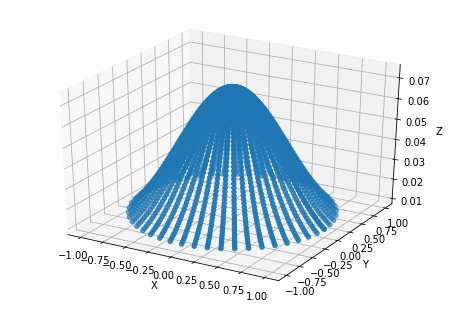

In [10]:
fig = plt.figure()
theta = np.r_[0:2*np.pi:50j]
radius = np.r_[0:1:50j]
x = np.array([r * np.cos(theta) for r in radius])
y = np.array([r * np.sin(theta) for r in radius])
z = np.array([drumhead_height(0, 1, r, theta, 1.5) for r in radius])
z1 = z+np.random.normal(loc=0.,scale=0.01,size=z.shape)


#initial guesses
p_guess = [.1,0,.1,0.,.1]
sigma = 1./np.sqrt(z.ravel())
sigma[np.isfinite(sigma) == False] = 1e30

popt, pcov = curve_fit(gauss_2d,(x.ravel(),y.ravel()),z.ravel(),p0=p_guess,sigma=sigma,maxfev=5000)
print(popt)

fig = plt.figure()
ax = Axes3D(fig)
#ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.jet)
ax.scatter(x,y,gauss_2d((x,y),*popt),zorder=1550)
#ax.scatter(x,y,z1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [11]:
import make_discrete_vdf as mdv
import numpy as np
import matplotlib.pyplot as plt
from fancy_plot import fancy_plot
from multiprocessing import Pool
import time
from scipy.optimize import curve_fit
import multi_fc_functions as mff
from scipy.interpolate import RectBivariateSpline
import geo_dist as gd

In [12]:
#set up plasma parameters
#                    Vx  ,  Vy,  Vz ,Wper,Wpar, Np
#pls_par = np.array([-380., -30., 30., 20., 40., 5.]) 
pls_par = np.array([-580., 10., -10., 20., 30., 15.]) 
#pls_par = np.array([-480., -100., -80., 20., 50., 25.])
#pls_par = np.array([-380., -100., 50., 30., 10., 50.]) 
#pls_par = np.array([-880., 100.,-150., 30., 10., 5.]) 
#mag_par = np.array([np.cos(np.radians(75.))*np.cos(.1), np.sin(np.radians(75.))*np.cos(.1), np.sin(.1)]) 
mag_par = np.array([-np.cos(np.radians(25.)),np.sin(np.radians(25.)), 0.]) 
#mag_par = np.array([-1.,0., 0.])

In [13]:
#Changed to mean km/s in p,q space 2018/10/19
samp = 1.5e1
#make a discrete VDF
#updated clip to a velocity width 2018/10/12 J. Prchlik
#Set to a "Total velocity width" which could be measured by the space craft 2018/10/15
vel_clip = 8.*np.sqrt(np.sum(pls_par[4:6]**2))
dis_vdf = mdv.make_discrete_vdf(pls_par,mag_par,pres=1.00,qres=1.00,clip=vel_clip)

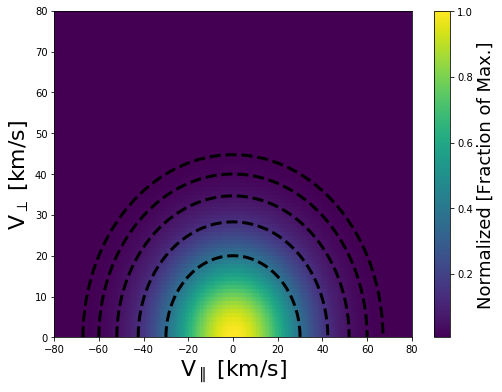

In [14]:
#"REAL" OBSERVATION
mdv.plot_vdf(dis_vdf)
plt.show()

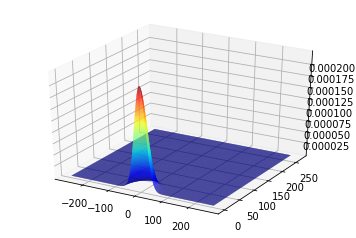

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(dis_vdf['pgrid'], dis_vdf['qgrid'], dis_vdf['vdf'], rstride=1, cstride=1, cmap=cm.jet)

In [16]:
def gauss_2d_vdf(vdf_test,a,x0,s0,x1,s1):
    """
    Gaussian function 
    Parameters
    ------------
    vdf_test: dictionary
        A dictiontary create by make_discrete_vdf (testing to see if I can pass a dictionary as an argument)
    a: float
        The amplitude of Gaussian
    x0: float
        The center value of the Gaussian
    sigma: float
        The one sigma width of the Gaussian
    Returns
    -------
    y:float or np.array
        The dependent value for a given independent value (x). 
    """
    x = vdf_test['pgrid'].ravel()
    y = vdf_test['qgrid'].ravel()
    return (a*np.exp(-(abs(x)-x0)**2/(2*s0**2))*np.exp(-(y-x1)**2/(2*s1**2))).ravel()

In [17]:
#initial guesses
p_guess = [.001,0,20,0.,21.]

popt, pcov = curve_fit(gauss_2d_vdf,dis_vdf,dis_vdf['vdf'].ravel(),p0=p_guess,maxfev=5000)

In [18]:
print(popt)

[  2.24483902e-04   3.34408375e-08   2.12132034e+01   7.44294315e-08
   1.41421356e+01]


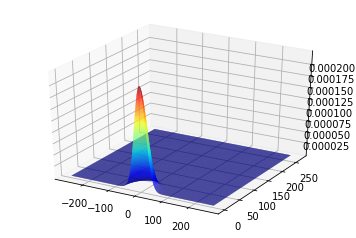

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(dis_vdf['pgrid'], dis_vdf['qgrid'], gauss_2d_vdf(dis_vdf,*popt).reshape(dis_vdf['pgrid'].shape), rstride=1, cstride=1, cmap=cm.jet)

In [31]:
#UNDERSTANDING TOLERANCES
from scipy import optimize
def myFun(x):
    return (x[0]-1.2)**2 + (x[1]+3.7)**2

tol_lev = [1e-91,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,10]
for i in tol_lev:
    print('######################################')
    print(i)
    powell = optimize.minimize(myFun,[0.,0],method='Powell',options={'xtol':i,'disp':True})
    print(powell.x)



######################################
1e-91
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 87
[ 1.2 -3.7]
######################################
0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 80
[ 1.2 -3.7]
######################################
0.2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 78
[ 1.2 -3.7]
######################################
0.3
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 77
[ 1.2 -3.7]
######################################
0.4
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 77
[ 1.2 -3.7]
######################################

In [23]:
#multi faraday cup solutions
fcs,big_arr = mff.create_multi_fc(dis_vdf,15,v_smp=40)

In [24]:
#get speed solution per observatory
v_angl = big_arr[:,0]
uv_angl = big_arr[:,5]
#thermal speed in GSE
w_angl = big_arr[:,1]
uw_angl = big_arr[:,6]
#get the density to compute the magnitude
n_angl = big_arr[:,2]
un_angl = big_arr[:,7]


#get angles from big_arr
phis   = np.radians(big_arr[:,3])
thetas = np.radians(big_arr[:,4])

#Number of processors to use when parallel processing
nproc = 8


In [25]:
#Use values with density greater than .1 and an uncertainty less than 10% 
top5 = ((un_angl/n_angl < 4.50) & (n_angl > 1e-1)) #np.sort(n_angl)[-6]
print(un_angl/n_angl)


#get v_gse solution (Produces the same solution as the Wind spacecraft solution)
#in /crater/observatories/wind/code/dvapbimax/sub_bimax_moments.pro
v_vec =  mdv.compute_gse_from_fit(phis[top5],thetas[top5],-v_angl[top5]) #np.dot(np.dot(np.dot(v_svdc.T,wp_svdc),u_svdc.T),v_angl)
vx,vy,vz = v_vec


[  2.07589132e-03   6.97128164e-05   6.19729537e-05   4.58297712e-02
   6.02501642e-05   8.23959644e-05   1.42016319e+06   6.30540584e-03
   1.41578688e+01   1.44598898e-02   1.44506023e+01   7.85755333e+04
   5.68888313e+06   3.05795571e-03   1.43077219e+01]


In [26]:
#Get Wper and Wpar vectors using maximum and minimum values
wv_par =  mdv.compute_gse_from_fit(np.radians(phis[top5]),np.radians(thetas[top5]),w_angl[top5])
wa = np.max(w_angl[top5])
we = np.min(w_angl[top5])


In [27]:
#compute angle between FC and the observed bulk velocity (cos(theta`))
n = np.median(np.abs(n_angl[top5]))

In [110]:
if we < 0.9*np.min(w_angl[top5]):
    we = np.min(w_angl[top5])
elif we > 1.1*np.max(w_angl[top5]):
    we = np.max(w_angl[top5])

if wa < 0.9*np.min(w_angl[top5]):
    wa = np.min(w_angl[top5])
elif wa > 1.1*np.max(w_angl[top5]):
    wa = np.max(w_angl[top5])

#make a discrete VDF with the incorrect parameters but the same grid
pls_par_bad = np.array([vx, vy, vz,we,wa,n])


In [98]:
#######Give info on best fit versus real solution######
print(pls_par)
print(pls_par_bad)

[-580.   10.  -10.   20.   30.   15.]
[-582.58102355   37.8354871   -10.45949606   21.27543484   28.82284274
   13.17374034]


In [99]:

######################################################################
######################################################################
#EVERYTHING BEFORE THIS WOULD BE MEASURED BY A SPACECRAFT
######################################################################
######################################################################

#Updated with vel_clip parameter 2108/10/12 J. Prchlik
dis_vdf_bad = mdv.make_discrete_vdf(pls_par_bad,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
#store the initial bad guess 
dis_vdf_bad_guess = dis_vdf_bad
dis_vdf_bad = dis_vdf_bad_guess

In [31]:
from multiprocessing import Pool

In [124]:
def gauss_2d_reconstruct(z,fcs,cur_vdf):
    """
    Function that reconstructs the 2D velocity distribution in the V parallel
    and V perp reference frame by assuming a 2D Gaussian.
    
    Parameters
    ------------
    z: list
        A list of input parameters used in the 2D velocity reconstruction. 
        The list must contain the following variables in the following order:
        vx,vy,vz,wper,wpar,den where vx is the x-component of the velocity in
        GSE coordinates, vy in the y-component of the velocity in GSE coordinates
        vz is the z-component of the velocity in GSE coordinates
    fcs: dictionary
        A dictionary of Faraday cups created by mff.create_multi_fc()
    cur_vdf: dictionary
        Dictionary of the velocity distribution created by make_discrete_vdf()
        
    Returns
    -------
    y:float or np.array
        The measured current of all Faraday Cups
    """
    vx = cur_vdf['u_gse'][0]
    vy = cur_vdf['u_gse'][1]
    vz = cur_vdf['u_gse'][2]
    
    vx,vy,vz,wper, wpar, den = z
    
    #                   Vx,Vy,Vz,Wper,Wpar, Np
    pls_par = np.array([vx,vy,vz,wper, wpar, den]) 
    
    #Get static variables from cur_vdf to add to creation of new guess VDF
    vel_clip = cur_vdf['pgrid'].max()
    pres     = np.mean(np.diff(cur_vdf['pgrid'][:,0]))
    qres     = np.mean(np.diff(cur_vdf['qgrid'][0,:]))
    
    #Create new VDF guess based on input parameters
    dis_vdf = mdv.make_discrete_vdf(pls_par,cur_vdf['b_gse'],pres=pres,qres=qres,clip=vel_clip) 
    
    looper = []
    #loop over all fc in fcs to populate with new VDF guess
    for i,key in enumerate(fcs.keys()):
        #add variation and store which faraday cup you are working with using key
        #Updated with varying integration sampling function 2018/10/12 J. Prchlik
        inpt_x = fcs[key]['x_meas'].copy()
        g_vdf  = dis_vdf.copy()
        peak   =  fcs[key]['peak'].copy()
        looper.append((inpt_x,g_vdf,samp,key))
        
    #process in parallel
    nproc = 8
    pool = Pool(processes=nproc)
    dis_cur = pool.map(mff.proc_wrap,looper)
    pool.close()
    pool.join()       
    
    
    #break into index value in looper and the 1D current distribution
    index   = np.array(zip(*dis_cur)[1])
    dis_cur = np.array(zip(*dis_cur)[0])


    #get sum squared best fit
    tot_err = np.zeros(dis_cur.shape[0])
    tot_int = np.zeros(dis_cur.shape[0])
    #Get error in each faraday cup
    for j,i in enumerate(index):
        tot_err[j] = np.sum((dis_cur[j,:] - fcs[i]['rea_cur'])**2)
        tot_int[j] = np.sum((fcs[i]['rea_cur'])**2)

    #print(tot_err)
    #total error for all fc
    tot_err[tot_int < 1e-25] = 0
    #fcs_err = np.median(tot_err)
    fcs_err = np.sum(tot_err**2) /np.sum(tot_int**2)
    #Remove really bad values from guess fitting

        
    return fcs_err

In [108]:
from scipy import optimize

In [111]:
print(gauss_2d_reconstruct(pls_par_bad,fcs,dis_vdf_bad))
print(gauss_2d_reconstruct(pls_par,fcs,dis_vdf))

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
0.00624370485577
(array([-580.,   10.,  -10.,   20.,   30.,   15.]), 1.0642788098761482e-37)
1.06427880988e-37


In [45]:
#initial guesses Wper,Wpar,Np 
###p_guess = pls_par_bad[3:]
###rranges=(slice(10,30,10),slice(10,30,10),slice(10,30,10)) 
###
###brute = optimize.brute(gauss_2d_reconstruct,rranges, args=(fcs,dis_vdf_bad),full_output=False,finish=optimize.fmin_powell)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   10.        ]), 2.5532353980544518e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   10.        ]), 2.5532353980544518e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         10.        ,   20.        ]), 1.2366775759836307e-17)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         20.        ,   10.        ]), 9.1443869899132969e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   10.        ,
         20.        ,   20.        ]), 3.621671786772866e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         10.        ,   10.        ]), 1.4398478463813944e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         10.        ,   20.        ]), 7.4906288087917173e-18)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   20.        ,
         20.    

(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         21.0472821 ,   13.88304606]), 3.9602634453000591e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.72414785,
         21.0472821 ,   13.88304606]), 3.9602758748420698e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.85663083,
         21.0472821 ,   13.88304606]), 3.9602958578149692e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         21.0472821 ,   13.88304606]), 3.9602634453000591e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         22.0472821 ,   13.88304606]), 3.869657249714711e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         23.6653161 ,   13.88304606]), 3.7772679653155802e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         25.08704687,   13.88304606]), 3.7423130633990886e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   36.79038934,
         27.3874

(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.93190679,
         29.57100384,   14.66502614]), 3.5262982186327723e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.90568051,
         29.58567387,   14.66651374]), 3.5262953797525996e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   33.79973384,
         29.88380674,   15.77191184]), 3.6158429583204447e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   26.22300382,
         29.10328476,   12.87794203]), 3.9195995427236809e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   30.90568051,
         29.58567387,   14.66651374]), 3.5262953797525996e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   29.11705722,
         29.40141763,   13.98334016]), 3.5820255088439926e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   32.01111049,
         29.69955049,   15.08873823]), 3.53633592793652e-19)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   31.13178254,
         29.60896

In [47]:
###print(brute)
###print(p_guess)
###print(pls_par[3:])

[ 31.07901647  29.77105172  14.7432968 ]
[ 21.27543484  28.82284274  13.17374034]
[ 20.  30.  15.]


In [48]:
import time

4.50611114502e-05


In [151]:
print(f3(resbrute,*params))

-1.39125074198e-15


In [112]:
#try actually using an initial guess instead of brute force
#NEED TO INCLUDE VELOCITY IN PARAMETER ESTIMATION OTHERWISE WILL TRY TO ACCOUNT FOR
#INCORRECT Vx,Vy,Vz values with LARGER VELOCITY WIDTHS
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'maxiter':10,'maxfev': 10})
x2 = time.time()
print(x2-x1)

(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
(array([-582.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0062437048557693548)
(array([-581.58102355,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0067848329980099821)
(array([-584.19905755,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0060025725834870654)
(array([-583.8875667 ,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0059776769386242238)
(array([-583.8875667 ,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0059776769386242238)
(array([-583.38851164,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274,   13.17374034]), 0.0060128602873348565)
(array([-583.69694464,   37.8354871 ,  -10.45949606,   21.27543484,
         28.82284274, 

(array([-585.08977624,  -11.22504806,   -5.29301439,   17.33077755,
         26.60435258,   15.34280472]), 0.016330836988803166)
(array([-583.83539989,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00036181292142658839)
(array([-582.83539989,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00013268712751316261)
(array([-581.21736589,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.3146026524240325e-05)
(array([-581.47739579,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.8771361409439532e-05)
(array([-578.59933187,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 0.00010081991138370951)
(array([-581.21736589,   13.30521952,   -7.87625523,   19.30310619,
         27.71359766,   14.25827253]), 2.3146026524240325e-05)
(array([-580.21736591,   13.30521952,   -7.87625523,   19.30310619,
         27.71359

(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.7272146 ]), 1.7026622439949638e-06)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73473433]), 1.7017722763271883e-06)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73949895]), 1.7019559553526335e-06)
(array([-577.68456179,    6.81249083,  -10.87928547,   23.54485522,
         29.23040076,   15.21119613]), 4.4551760601517649e-05)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.47199921,   14.73473433]), 1.7017722763271883e-06)
(array([-577.68456179,    6.81249083,  -10.87928547,   23.54485522,
         29.23040076,   15.21119613]), 4.4551760601517649e-05)
(array([-585.73611343,   15.31158306,   -6.94826783,   17.99233364,
         27.24487972,   13.96380294]), 0.0017663779448971338)
(array([-580.75998084,   10.05885517,   -9.37777035,   21.42398071,
         28.4719

(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.21721282,   14.88173888]), 1.4950625706445867e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.10288234,   14.88173888]), 1.4980028987106483e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.17354246,   14.88173888]), 1.4826025224342694e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.1629688 ,   14.88173888]), 1.4819162825222736e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.15773177,   14.88173888]), 1.4819394376474435e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.16820582,   14.88173888]), 1.4821352719450649e-07)
(array([-580.08169064,   10.02062438,   -9.92521603,   21.54783743,
         29.1629688 ,   14.88173888]), 1.4819162825222736e-07)
(array([-579.40340044,    9.30463183,  -10.25637838,   22.0156008 ,
         29.330

(array([-579.97433917,   10.11374302,  -10.06975269,   21.52123242,
         29.34269204,   15.0418225 ]), 8.4089632355496971e-08)
(array([-579.97433917,   10.11374302,  -10.07033519,   21.52123242,
         29.34269204,   15.0418225 ]), 8.4089634382976275e-08)
(array([-579.97433917,   10.11374302,  -10.07004394,   21.52123242,
         29.34269204,   15.0418225 ]), 8.4089628599770842e-08)
(array([-579.97433917,   10.11374302,  -10.07004394,   22.52123242,
         29.34269204,   15.0418225 ]), 7.0245943398914333e-07)
(array([-579.97433917,   10.11374302,  -10.07004394,   19.90319842,
         29.34269204,   15.0418225 ]), 1.2922493633482535e-07)
(array([-579.97433917,   10.11374302,  -10.07004394,   21.52123242,
         29.34269204,   15.0418225 ]), 8.4089628599770842e-08)
(array([-579.97433917,   10.11374302,  -10.07004394,   20.90319844,
         29.34269204,   15.0418225 ]), 4.5355504982533284e-08)
(array([-579.97433917,   10.11374302,  -10.07004394,   20.52123243,
         29.342

(array([-579.87937452,   10.0250517 ,   -9.78337742,   21.01246539,
         29.48459978,   14.99642169]), 2.844257668215218e-08)
(array([-579.87937452,   10.0250517 ,  -10.20899179,   21.01246539,
         29.48459978,   14.99642169]), 2.1934546236020167e-08)
(array([-579.87937452,   10.0250517 ,  -10.18042619,   21.01246539,
         29.48459978,   14.99642169]), 2.1904549939180614e-08)
(array([-579.87937452,   10.0250517 ,  -10.17856697,   21.01246539,
         29.48459978,   14.99642169]), 2.1904427488668742e-08)
(array([-579.87937452,   10.0250517 ,  -10.17843473,   21.01246539,
         29.48459978,   14.99642169]), 2.1904427403693083e-08)
(array([-579.87937452,   10.0250517 ,  -10.17830382,   21.01246539,
         29.48459978,   14.99642169]), 2.1904428448775479e-08)
(array([-579.87937452,   10.0250517 ,  -10.17843473,   21.01246539,
         29.48459978,   14.99642169]), 2.1904427403693083e-08)
(array([-579.87937452,   10.0250517 ,  -10.17843473,   22.01246539,
         29.4845

(array([-579.90407667,    8.51008183,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 1.2101686600811566e-07)
(array([-579.90407667,   10.12811583,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 2.7459441957737662e-09)
(array([-579.90407667,    9.51008185,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 5.3110519813330263e-09)
(array([-579.90407667,   10.51008183,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 4.7965549339761925e-09)
(array([-579.90407667,   10.03710658,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 2.6778212019251187e-09)
(array([-579.90407667,   10.04429603,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 2.6803899975707175e-09)
(array([-579.90407667,   10.00242574,  -10.26489826,   20.2265851 ,
         29.67688737,   14.92024685]), 2.6720212179814168e-09)
(array([-579.90407667,   10.00116884,  -10.26489826,   20.2265851 ,
         29.676

(array([-579.92297711,   10.0735915 ,  -10.12844078,   20.25178995,
         29.70639094,   14.92410621]), 1.6191884504465053e-09)
(array([-579.91630436,   10.07398885,  -10.13407315,   20.25261595,
         29.71378606,   14.92560023]), 1.6136834054272215e-09)
(array([-579.91682791,   10.07395767,  -10.13363123,   20.25255114,
         29.71320583,   14.925483  ]), 1.6136996350356945e-09)
(array([-579.91578081,   10.07402002,  -10.13451507,   20.25268075,
         29.71436629,   14.92571745]), 1.6137379750422654e-09)
(array([-579.91630436,   10.07398885,  -10.13407315,   20.25261595,
         29.71378606,   14.92560023]), 1.6136834054272215e-09)
(array([-579.91630436,   11.07398885,  -10.13407315,   20.25261595,
         29.71378606,   14.92560023]), 3.6505399774867288e-08)
(array([-579.91630436,    8.45595485,  -10.13407315,   20.25261595,
         29.71378606,   14.92560023]), 1.1510520187462024e-07)
(array([-579.91630436,   10.07398885,  -10.13407315,   20.25261595,
         29.713

(array([-579.97316168,    9.98371561,  -10.07552497,   20.20309951,
         29.72861848,   14.9317774 ]), 7.6992314419669028e-10)
(array([-579.97091068,   10.02729341,  -10.08270288,   20.22461729,
         29.6921907 ,   14.92282771]), 1.2628618835171093e-09)
(array([-579.97316168,    9.98371561,  -10.07552497,   20.20309951,
         29.72861848,   14.9317774 ]), 7.6992314419669028e-10)
(array([-579.97680386,    9.91320524,  -10.06391087,   20.16828302,
         29.78755988,   14.94625831]), 3.1478794690180124e-10)
(array([-579.97889888,    9.87264707,  -10.05723034,   20.14825627,
         29.82146348,   14.95458786]), 1.8523427796011818e-10)
(array([-579.98228869,    9.80702257,  -10.04642101,   20.11585231,
         29.87632065,   14.96806534]), 1.0427124670956783e-10)
(array([-579.98231954,    9.80642535,  -10.04632264,   20.11555741,
         29.87681988,   14.968188  ]), 1.0408516289584786e-10)
(array([-579.98236946,    9.80545904,  -10.04616347,   20.11508027,
         29.877

(array([-581.08109482,   11.16180296,   -9.50271673,   19.30930458,
         29.62298847,   14.79634619]), 2.0088428908241953e-06)
(array([-579.98359822,   10.00330268,  -10.03854867,   20.06616163,
         29.89363228,   14.96637675]), 2.7116420464732981e-11)
(array([-580.40280461,   10.4458104 ,   -9.83387909,   19.77706797,
         29.79025555,   14.90143086]), 4.2785417505618695e-08)
(array([-579.72451442,    9.72981787,  -10.16504143,   20.24483133,
         29.95752261,   15.00651552]), 7.5171025878560175e-09)
(array([-579.92895274,    9.94561976,  -10.06522829,   20.10384632,
         29.90710791,   14.97484274]), 8.6809189404504489e-11)
(array([-579.96028957,    9.97869843,  -10.04992868,   20.08223577,
         29.89938022,   14.96998786]), 3.7252594716843998e-11)
(array([-579.98230696,   10.00193965,  -10.0391791 ,   20.0670521 ,
         29.8939507 ,   14.9665768 ]), 2.728855799917611e-11)
(array([-579.98781923,   10.00775832,  -10.03648784,   20.06325072,
         29.8925

(array([-579.99274695,   10.00025166,  -10.01613812,   19.41569225,
         29.96391151,   14.98698529]), 4.1196300331991794e-09)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.41569222,
         29.96391151,   14.98698529]), 1.0399543203030427e-09)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.07974938,
         29.96391151,   14.98698529]), 2.322961026021847e-12)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.05433309,
         29.96391151,   14.98698529]), 9.2264076872264774e-13)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.03302496,
         29.96391151,   14.98698529]), 5.4996443941505857e-13)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.02532857,
         29.96391151,   14.98698529]), 5.11830521427657e-13)
(array([-579.99274695,   10.00025166,  -10.01613812,   19.79246822,
         29.96391151,   14.98698529]), 6.817218923092794e-11)
(array([-579.99274695,   10.00025166,  -10.01613812,   20.02151366,
         29.9639115

(array([-579.99943203,    9.99980183,  -10.00180298,   19.99322603,
         30.0046904 ,   14.99955614]), 1.4819768524637447e-16)
(array([-579.99939375,    9.99987541,  -10.00160488,   19.99472878,
         30.00431247,   14.99983308]), 7.8253267053345026e-17)
(array([-579.99936521,    9.99993028,  -10.00145714,   19.99584949,
         30.00403062,   15.00003961]), 4.8369081816024952e-17)
(array([-579.99840773,   10.00177082,   -9.9965017 ,   20.03344054,
         29.99457677,   15.00696716]), 5.6186057380179549e-14)
(array([-579.99933466,    9.999989  ,  -10.00129906,   19.99704866,
         30.00372904,   15.0002606 ]), 3.003333513104478e-17)
(array([-579.99931022,   10.00003598,  -10.00117256,   19.99800829,
         30.0034877 ,   15.00043745]), 2.2094261175166922e-17)
(array([-579.9989655 ,   10.00069863,   -9.99938845,   20.01154221,
         30.00008403,   15.00293158]), 1.1130148910572095e-15)
(array([-579.99929003,   10.0000748 ,  -10.00106806,   19.998801  ,
         30.0032

(array([-579.9991525 ,   10.00234127,  -10.00181898,   20.00004779,
         30.00120601,   15.00029133]), 3.1644113481971279e-18)
(array([-579.9991525 ,   10.00234127,  -10.00181898,   19.99957738,
         30.00120601,   15.00029133]), 3.0347192996148962e-18)
(array([-579.9991525 ,   10.00234127,  -10.00181898,   19.99946188,
         30.00120601,   15.00029133]), 3.0300862087351501e-18)
(array([-579.9991525 ,   10.00234127,  -10.00181898,   19.99947516,
         30.00120601,   15.00029133]), 3.0300326507272988e-18)
(array([-579.9991525 ,   10.00234127,  -10.00181898,   19.99948831,
         30.00120601,   15.00029133]), 3.0301319283406565e-18)
(array([-579.9991525 ,   10.00234127,  -10.00181898,   19.99947516,
         30.00120601,   15.00029133]), 3.0300326507272988e-18)
(array([-579.3208623 ,    9.28634873,  -10.33298132,   20.46723854,
         30.16847308,   15.10537599]), 2.8720898730275284e-07)
(array([-581.09664911,   11.16084156,   -9.46598704,   19.24261811,
         29.730

In [127]:
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',tol=1,options={'return_all':True,'disp':True})
x2 = time.time()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 6
         Function evaluations: 249


In [136]:
#print(powell)
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

####x1 = time.time()
####bfgs = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='BFGS')
####x2 = time.time()
####print(x2-x1)

[-580.   10.  -10.   20.   30.   15.]
[-580.07795448   10.04308948   -9.85828623   20.04068832   30.16287756
   15.08722464]
16.8326537649


In [137]:
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':0.1,'disp':True})
x2 = time.time()
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 15
         Function evaluations: 904
[-580.   10.  -10.   20.   30.   15.]
[-579.99990079    9.9999613   -10.00002621   20.00014647   29.99998381
   14.99998034]
62.4376244982


In [ ]:
p_guess = pls_par_bad
#p_guess = [ 21.27543484,  28.82284274, 13.17374034]
x1 = time.time()
powell = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Powell',options={'xtol':10.,'disp':True})
x2 = time.time()
print(pls_par)
print(powell.x)
print((x2-x1)/60.)

Process PoolWorker-34531:
Process PoolWorker-34532:
Process PoolWorker-34533:
Process PoolWorker-34530:
Process PoolWorker-34534:
Traceback (most recent call last):
Process PoolWorker-34535:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-34529:
Traceback (most recent call last):
Process PoolWorker-34536:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiproce

    arr = mpl.create_mid_point_arr_pqr_samp(z_lo,z_hi,x_lo, x_hi, y_lo, y_hi,samp,z_samp,x_samp,y_samp)
    arr = mpl.create_mid_point_arr_pqr_samp(z_lo,z_hi,x_lo, x_hi, y_lo, y_hi,samp,z_samp,x_samp,y_samp)
    area_cal = np.sum(int_3d(arr[:,4],arr[:,2],arr[:,0],*args)*np.prod(arr[:,1::2],axis=1))
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "mid_point_loop.pyx", line 129, in mid_point_loop.create_mid_point_arr_pqr_samp
  File "make_discrete_vdf.py", line 1086, in int_3d
  File "mid_point_loop.pyx", line 129, in mid_point_loop.create_mid_point_arr_pqr_samp
    hold_ifunc=ifunc)
    hold_ifunc=ifunc)
    hold_ifunc=ifunc)
    hold_ifunc=ifunc)
    hold_ifunc=ifunc)
    hold_ifunc=ifunc)
  File "make_discrete_vdf.py", line 1224, in vdf_calc
  File "make_discrete_vdf.py

Traceback (most recent call last):
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
  

  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/queues.py", line 374, in get
    racquire()
    return recv()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
    racquire()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Process PoolWorker-34565:
Process PoolWorker-34562:
Process PoolWorker-34564:
Process PoolWorker-34561:
Process PoolWorker-34563:
Process PoolWorker-34567:
Process PoolWorker-34568:
Process PoolWorker-34566:
Traceback 

  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
    task = get()
    task = get()
    task = get()
    task = get()
    task = get()
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multipro

    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/Volumes/Pegasus/jprchlik/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(

In [ ]:
####x1 = time.time()
####newton = optimize.minimize(gauss_2d_reconstruct,p_guess, args=(fcs,dis_vdf_bad),method='Nelder-Mead')
####x2 = time.time()
####print(x2-x1)

In [ ]:
#Initial guess around current guess of 2d VDF
pls_par_bad = np.array([-582.58102355,   37.8354871 ,  -10.45949606,   31.12637808, 29.80541342,   14.76697946])
dis_vdf_bad_guess = mdv.make_discrete_vdf(powell.x,mag_par,pres=1.00,qres=1.00,clip=vel_clip)
pred_grid = dis_vdf_bad_guess['vdf'].copy()
default_grid = pred_grid.copy()
good_vdf_values =  np.isfinite(pred_grid)
pred_grid[good_vdf_values == False] = np.min(pred_grid[good_vdf_values])
pred_grid -= np.min(pred_grid)
pred_grid /= np.sum(pred_grid)

#Get the initial distribution based on input parameters 2018/09/19 J. Prchlik 
for k,i in enumerate(fcs.keys()):
    i = 'fc_{0:1d}'.format(k)
    #updated using dynamic sampling 2018/10/12 J. Prchlik
    fcs[i]['init_guess'] = mdv.arb_p_response(fcs[i]['x_meas'],dis_vdf_bad,samp)

#Run MC so I can create a plot comparing observations
iters = 1
kernel = 500
fcs,dis_vdf_bad,pred_grid,kernel,improved,ip,iq,n_p_prob,counter,per_err_list,ker_sze_list = mff.mc_reconstruct(fcs,nproc,dis_vdf_bad,
                                                                             pred_grid,kernel,iters,verbose=False,
                                                                             default_grid=default_grid,counter=0,
                                                                             return_convergence=True,min_kernel=15,tol_cnt=300)


In [ ]:
mff.create_fc_grid_plot(fcs)
plt.show()